In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import imghdr
import pandas as pd

/Users/devin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/qx/w38nm8p540l84z4yf2h3sm2h0000gn/T/ipykernel_1381/2167983068.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
data_dir = '../data'
train_dir = 'train_data'
test_dir = 'test_data_v2'

In [4]:
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

### check dodgy data

In [5]:
# check train dataset
for class_name in ['AI', 'human']:
    for image in os.listdir(os.path.join(data_dir, train_dir, class_name)):
        image_path = os.path.join(data_dir, train_dir, class_name, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not have a valid extension')
        except Exception as e:
            print('Issue with image {}'.format(image_path))


KeyboardInterrupt: 

In [ ]:
# check test dataset
for image in os.listdir(os.path.join(data_dir, test_dir)):
    image_path = os.path.join(data_dir, test_dir, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not have a valid extension')
    except Exception as e:
        print('Issue with image {}'.format(image_path))

### load data

In [6]:
data = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, train_dir))

Found 79950 files belonging to 2 classes.


In [22]:
def swap_label(image, label):
    new_label = 1- label
    return image, new_label

In [26]:
# 1 for AI, 0 for human
swapped_data = data.map(swap_label)

In [28]:
data_iterator = swapped_data.as_numpy_iterator()

In [31]:
batch = data_iterator.next()

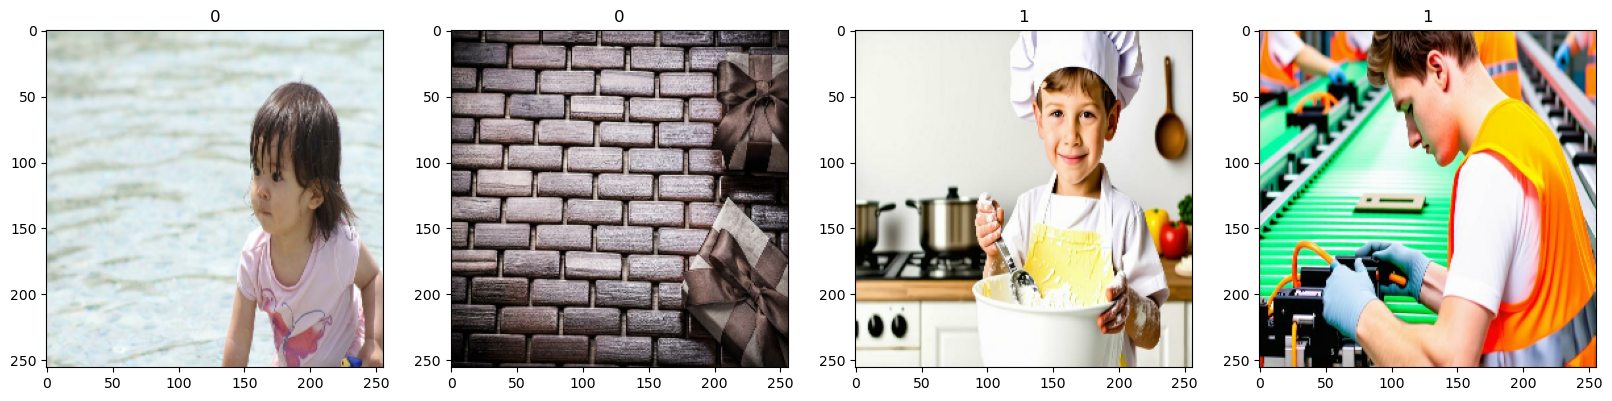

In [32]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in  enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Scale Data

In [33]:
scaled_data = swapped_data.map(lambda x, y: (x/255, y))

### Split Data

In [38]:
len(scaled_data)

2499

In [46]:
train_size = int(len(scaled_data)*0.7)
val_size = int(len(scaled_data)*0.3)+1

In [49]:
train_data = scaled_data.take(train_size)
val_data = scaled_data.skip(train_size).take(val_size)

### Build CNN Base Model

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [59]:
model = Sequential()

In [60]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/devin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
compile??

Signature:
compile(
    source,
    filename,
    mode,
    flags=0,
    dont_inherit=False,
    optimize=-1,
    *,
    _feature_version=-1,
)
Docstring:
Compile source into a code object that can be executed by exec() or eval().

The source code may represent a Python module, statement or expression.
The filename will be used for run-time error messages.
The mode must be 'exec' to compile a module, 'single' to compile a
single (interactive) statement, or 'eval' to compile an expression.
The flags argument, if present, controls which future statements influence
the compilation of the code.
The dont_inherit argument, if true, stops the compilation inheriting
the effects of any future statements in effect in the code calling
compile; if absent or false these statements do influence the compilation,
in addition to any features explicitly specified.
Type:      builtin_function_or_method

In [62]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
log_dir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20


 605/1749 ━━━━━━━━━━━━━━━━━━━━ 10:45 564ms/step - accuracy: 0.7628 - loss: 0.5416

KeyboardInterrupt: 